# **NLU - 문장 유사도 계산 (STS)**

## **과제 목표**

> 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력

## **학습 데이터셋(Dataset description)**

- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)
  - AIRBNB (에어비앤비 리뷰)
  - policy (정책 뉴스)
  - paraKOQC (스마트홈 쿼리)

  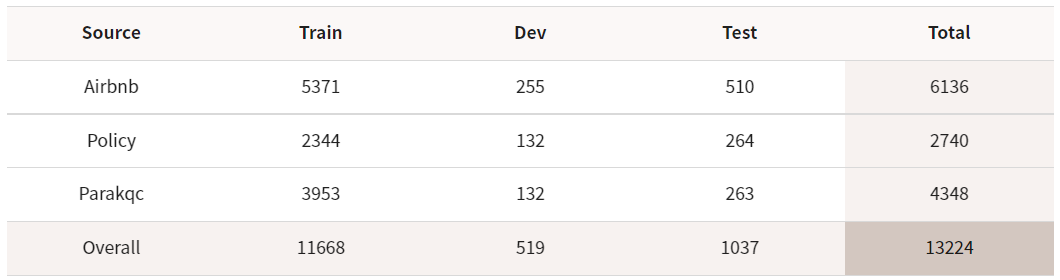

## **설치 및 설정(Set up)**

In [ ]:
# 설치
!pip install transformers

In [ ]:
!pip install datasets

In [2]:
# 라이브러리
import os
import sys
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

## **데이터셋 불러오기(Dataset Load)**

In [4]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

## **데이터 전처리(Data Preprocessing)**
- 결측값 확인 후 제거
- 중복 행 확인 후 제거
- 데이터 정제
 - 특수문자 제거
 - 한글, 영어, 숫자를 제외한 모든 문자열 제거

## **EDA(Exploratory Data Analysis)**
- 데이터 분석(가설 검정??)
- 시각화